У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, mean_squared_error

from sklearn.preprocessing import LabelEncoder

In [2]:
cust_df = pd.read_csv('./customer_segmentation_train.csv')
cust_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
input_data = cust_df 
input_cols = list(input_data.columns)

# Identify numeric and categorical columns
numeric_cols = input_data.select_dtypes(include=np.number).columns.tolist()
category_cols = input_data.select_dtypes(include='object').columns.tolist()

numeric_cols, category_cols

(['ID', 'Age', 'Work_Experience', 'Family_Size'],
 ['Gender',
  'Ever_Married',
  'Graduated',
  'Profession',
  'Spending_Score',
  'Var_1',
  'Segmentation'])

In [5]:
numeric_cols.remove('ID')
category_cols.remove('Segmentation')

In [6]:
num_imputer = SimpleImputer(strategy='most_frequent')
num_imputer.fit(input_data[numeric_cols])
input_data[numeric_cols] = num_imputer.transform(input_data[numeric_cols])

In [7]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
cat_imputer.fit(input_data[category_cols])
input_data[category_cols] = cat_imputer.transform(input_data[category_cols])

In [8]:
input_data.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [9]:
numeric_scaler = MinMaxScaler()
numeric_scaler.fit(input_data[numeric_cols])
input_data[numeric_cols] = numeric_scaler.transform(input_data[numeric_cols])

In [10]:
for column in category_cols:
    print(column, '-', input_data[column].nunique())

Gender - 2
Ever_Married - 3
Graduated - 3
Profession - 10
Spending_Score - 3
Var_1 - 8


In [11]:
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoder.fit(input_data[category_cols])
input_data[cat_encoder.get_feature_names_out(category_cols)] = cat_encoder.transform(input_data[category_cols])

In [12]:
category_cols = list(cat_encoder.get_feature_names_out(category_cols))

In [13]:
input_data.Segmentation.value_counts()

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64

In [14]:
target_encoder = LabelEncoder()
input_data.loc[:, 'Segmentation_enc'] = target_encoder.fit_transform(input_data['Segmentation'])

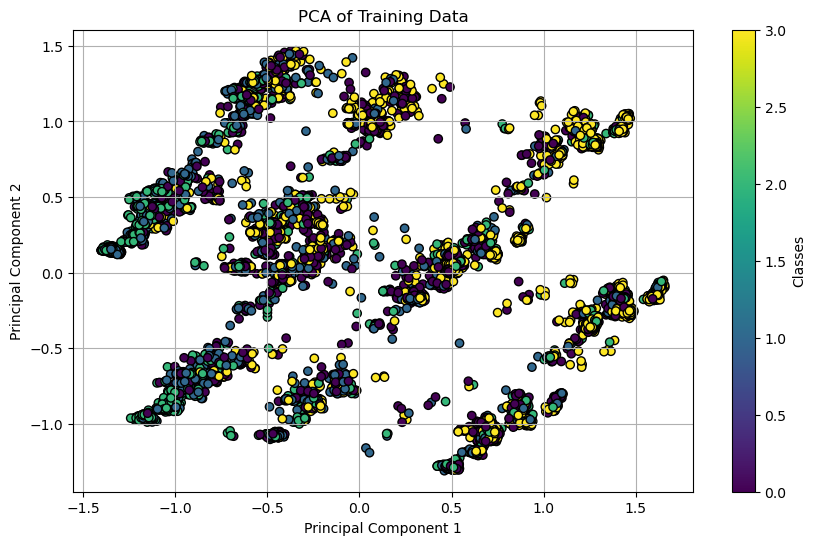

In [15]:
pca = PCA(n_components=2)
pca.fit(input_data[numeric_cols+category_cols])
X_train_pca = pca.transform(input_data[numeric_cols+category_cols])

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=input_data['Segmentation_enc'], cmap='viridis', edgecolors='k')
plt.colorbar(label='Classes')
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [16]:
input_data = input_data[numeric_cols+category_cols+['Segmentation']]

In [17]:
train_df, test_df = train_test_split(input_data, test_size=0.2, random_state=42, stratify=input_data['Segmentation'])

target_col = 'Segmentation'
input_data_for_model = input_data.drop(columns=[target_col])
cols_for_model = input_data_for_model.columns.tolist()

train_inputs, train_targets = train_df[cols_for_model], train_df[target_col]
test_inputs, test_targets = test_df[cols_for_model], test_df[target_col]


In [18]:
train_inputs.head()

,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Ever_Married_missing,Graduated_No,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_missing
917,0.197183,0.642857,0.000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3398,0.760563,0.071429,0.125,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2045,0.211268,0.071429,0.375,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8060,0.422535,0.000000,0.625,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4604,0.140845,0.642857,0.000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
test_inputs.head()

,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Ever_Married_missing,Graduated_No,Graduated_Yes,...,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Var_1_missing
6862,0.323944,0.857143,0.250,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3396,0.042254,0.285714,0.375,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6302,0.253521,0.000000,0.000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3329,0.126761,0.000000,0.125,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7901,0.000000,0.000000,0.625,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

from sklearn.svm import LinearSVC

In [21]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(train_inputs[numeric_cols], train_targets)

In [22]:
cat_feature_indices = [train_inputs.columns.get_loc(col) for col in category_cols]

smote_nc = SMOTENC(categorical_features=cat_feature_indices, categorical_encoder=None)
X_train_smote_nc, y_train_smote_nc = smote_nc.fit_resample(train_inputs, train_targets)


In [23]:
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(train_inputs, train_targets)

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report

In [26]:
lr_original = LogisticRegression(multi_class='ovr', random_state=42)
ovr_model = OneVsRestClassifier(lr_original)
ovr_model.fit(train_inputs, train_targets)
ovr_predictions = ovr_model.predict(test_inputs)

print("Classification Report - Original Data:")
print(classification_report(test_targets, ovr_predictions))


Classification Report - Original Data:
              precision    recall  f1-score   support

           A       0.43      0.46      0.44       394
           B       0.42      0.17      0.24       372
           C       0.49      0.63      0.55       394
           D       0.65      0.76      0.70       454

    accuracy                           0.52      1614
   macro avg       0.50      0.51      0.49      1614
weighted avg       0.50      0.52      0.50      1614



In [35]:
lr_smote = LogisticRegression(multi_class='ovr', random_state=42)
ovr_model_smote = OneVsRestClassifier(lr_smote)
ovr_model_smote.fit(X_train_smote, y_train_smote)
ovr_predictions_smote = ovr_model_smote.predict(test_inputs[numeric_cols])

print("Classification Report - SMOTE Data:")
print(classification_report(test_targets, ovr_predictions_smote))

Classification Report - SMOTE Data:
              precision    recall  f1-score   support

           A       0.33      0.29      0.31       394
           B       0.28      0.08      0.13       372
           C       0.36      0.42      0.39       394
           D       0.50      0.77      0.60       454

    accuracy                           0.41      1614
   macro avg       0.37      0.39      0.36      1614
weighted avg       0.37      0.41      0.37      1614



In [36]:
lr_smote_nc = LogisticRegression(multi_class='ovr', max_iter=10000, random_state=42)
ovr_model_smote_nc = OneVsRestClassifier(lr_smote_nc)
ovr_model_smote_nc.fit(X_train_smote_nc, y_train_smote_nc)
ovr_predictions_smote_nc = ovr_model_smote_nc.predict(test_inputs)

print("Classification Report - SMOTENC Data:")
print(classification_report(test_targets, ovr_predictions_smote_nc))

Classification Report - SMOTENC Data:
              precision    recall  f1-score   support

           A       0.42      0.47      0.44       394
           B       0.39      0.23      0.29       372
           C       0.50      0.59      0.54       394
           D       0.67      0.72      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



In [37]:
lr_smote_tomek = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)
ovr_model_smote_tomek = OneVsRestClassifier(lr_smote_nc)
ovr_model_smote_tomek.fit(X_train_tomek, y_train_tomek)
ovr_predictions_smote_tomek = ovr_model_smote_tomek.predict(test_inputs)

print("Classification Report - SMOTE-Tomek Data:")
print(classification_report(test_targets, ovr_predictions_smote_tomek))

Classification Report - SMOTE-Tomek Data:
              precision    recall  f1-score   support

           A       0.43      0.31      0.36       394
           B       0.34      0.45      0.39       372
           C       0.57      0.48      0.53       394
           D       0.66      0.74      0.70       454

    accuracy                           0.50      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.51      0.50      0.50      1614



Для порівняння моделей проаналізувала кожну з метрик, в цілому вони показують посередній результат. хотілось би краще.

Для поліпшення результатів можна спробувати інші методи балансування класів або параметри моделей.

Після вивчення додатковох літератури детальніше, спробую погратись  з параметрамии та моделями 

